# 2. Extinctions

In [1]:
import pathlib
from zipfile import ZipFile

import numpy as np
import scipy as sp
from scipy.interpolate import splrep, BSpline
import pandas as pd

from astropy.coordinates import SkyCoord
from astropy_healpix import HEALPix
import dustmaps
import dustmaps.config
import dustmaps.gaia_tge

import config
import utils

hpx_order=7 --> (hpx_nside=128, hpx_npix=196608)
model_hpx_order=5 --> (model_hpx_nside=32, model_hpx_npix=12288)


In [2]:
cache_path = pathlib.Path(config.cache_path)
cache_path.mkdir(exist_ok=True)

fig_path = pathlib.Path(config.fig_path)
fig_path.mkdir(exist_ok=True)

## Load RGB stars catalogue

In [3]:
usecols = ['source_id', 'l', 'b', 'mh_xgboost', 'teff_xgboost']
rgb = pd.read_hdf(cache_path / 'rgb.hdf5', key='rgb', columns=usecols)
print("Num. of RGB stars:", len(rgb))
rgb

Num. of RGB stars: 17558141


,source_id,l,b,mh_xgboost,teff_xgboost
0,15741055975040,176.739184,-48.572035,-0.144,5065.8
1,25980257976960,176.369336,-48.732076,-0.083,5017.9
2,66627828480768,176.483565,-48.171322,-0.401,4499.0
3,82467667849472,176.209301,-48.607026,0.114,4938.3
4,101193725229056,175.755174,-48.727781,-0.478,4980.2
...,...,...,...,...,...
17558136,6917522464931567744,48.777837,-28.451061,-0.226,4948.4
17558137,6917522778464669696,48.764318,-28.403106,-0.267,4807.5
17558138,6917523083406587264,48.835692,-28.452592,-0.550,4953.4
17558139,6917523495723447552,48.879485,-28.434142,0.114,4838.6


## Estimate extinctions for every star

### Load dustmap

Manual: https://dustmaps.readthedocs.io/en/latest/

See also https://gea.esac.esa.int/archive/documentation/GDR3/Gaia_archive/chap_datamodel/sec_dm_astrophysical_parameter_tables/ssec_dm_total_galactic_extinction_map.html#total_galactic_extinction_map-a0

In [4]:
dustmaps.config.config['data_dir'] = str(cache_path / 'dustmaps.data')
dustmaps.gaia_tge.fetch()
dm = dustmaps.gaia_tge.GaiaTGEQuery(healpix_level=config.hpx_order)

Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.


### Estimate A_0 for every star

A_0 is the monochromatic extinction at 541.4 nm ([Fitzpatrick 1999](https://iopscience.iop.org/article/10.1086/316293); [Delchambre et al. 2023](http://dx.doi.org/10.1051/0004-6361/202243423))

In [5]:
# Note the frame!
l = rgb['l'].values
b = rgb['b'].values
co = SkyCoord(l, b, frame='galactic', unit='deg')

# Get the A_0 for every star
rgb['a0'] = dm.query(co)
print("NaNs in A0:", rgb['a0'].isnull().sum())

NaNs in A0: 1851610


In [6]:
# Drop the stars with no A_0
mask = rgb['a0'].isnull()
rgb = rgb[~mask].copy()
print("Num. of stars after A_0 cleaning:", len(rgb))

Num. of stars after A_0 cleaning: 15706531


In [7]:
# It's important for the fitting below
# Don't ask
rgb['a0'] = rgb['a0'].astype(float)
rgb.dtypes

source_id         int64
l               float64
b               float64
mh_xgboost      float64
teff_xgboost    float64
a0              float64
dtype: object

### Estimate A_G, A_BP, and A_RP for every star

Use the [Fitzpatrick et al. (2019)](https://iopscience.iop.org/article/10.3847/1538-4357/ab4c3a) 3rd-order polynomial approximation

Data: https://www.cosmos.esa.int/web/gaia/edr3-extinction-law

In [8]:
# Download the Fitzpatrick et al. (2019) extinctions approximation table

url = 'https://www.cosmos.esa.int/documents/29201/1658422/Fitz19_EDR3_extinctionlawcoefficients.zip'
file_name = cache_path / 'Fitz19_EDR3_extinctionlawcoefficients.zip'
utils.download_file(url, file_name)

Starting download from https://www.cosmos.esa.int/documents/29201/1658422/Fitz19_EDR3_extinctionlawcoefficients.zip
File 'cache/Fitz19_EDR3_extinctionlawcoefficients.zip' already downloaded
Done


In [9]:
with ZipFile(file_name, 'r') as zf:
    with zf.open('Fitz19_EDR3_HRDTop.csv') as f:
        fitz0 = pd.read_csv(f)
#fitz0

In [10]:
# See https://www.cosmos.esa.int/web/gaia/edr3-extinction-law
# km = a1 + a2*X + a3*X^2 + a4*X^3 + a5*A0 + a6*A0^2 + a7*A0^3 + a8*A0*X + a9*A0*X^2 + a10*X*A0*2

a0 = rgb['a0']
Teff_0 = 5040.0  # K
teffnorm = rgb['teff_xgboost'] / Teff_0

mask = (fitz0['Xname'] == 'TeffNorm') & (fitz0['Kname'] == 'kG')
fitz = fitz0[mask].to_dict(orient='records')[0]
kG = fitz['Intercept'] + fitz['X']*teffnorm + fitz['X2']*teffnorm**2 + fitz['X3']*teffnorm**3 \
     + fitz['A']*a0 + fitz['A2']*a0**2 + fitz['A3']*a0**3 \
     + fitz['XA']*a0*teffnorm + fitz['AX2']*a0*teffnorm**2 + fitz['XA2']*a0**2*teffnorm
rgb['ag'] = kG * a0

mask = (fitz0['Xname'] == 'TeffNorm') & (fitz0['Kname'] == 'kBP')
fitz = fitz0[mask].to_dict(orient='records')[0]
kBP = fitz['Intercept'] + fitz['X']*teffnorm + fitz['X2']*teffnorm**2 + fitz['X3']*teffnorm**3 \
      + fitz['A']*a0 + fitz['A2']*a0**2 + fitz['A3']*a0**3 \
      + fitz['XA']*a0*teffnorm + fitz['AX2']*a0*teffnorm**2 + fitz['XA2']*a0**2*teffnorm
rgb['abp'] = kBP * a0

mask = (fitz0['Xname'] == 'TeffNorm') & (fitz0['Kname'] == 'kRP')
fitz = fitz0[mask].to_dict(orient='records')[0]
kRP = fitz['Intercept'] + fitz['X']*teffnorm + fitz['X2']*teffnorm**2 + fitz['X3']*teffnorm**3 \
      + fitz['A']*a0 + fitz['A2']*a0**2 + fitz['A3']*a0**3 \
      + fitz['XA']*a0*teffnorm + fitz['AX2']*a0*teffnorm**2 + fitz['XA2']*a0**2*teffnorm
rgb['arp'] = kRP * a0

## Select stars by metallicity

Later this will be our sample to modelling

In [11]:
mask = (-3.0 < rgb['mh_xgboost']) & (rgb['mh_xgboost'] < -1.0)
rgb_lome = rgb[mask]
print("Num. of RGB stars after metallicity selection:", len(rgb_lome))

Num. of RGB stars after metallicity selection: 434119


In [12]:
rgb_lome[['mh_xgboost', 'a0', 'ag', 'abp', 'arp']].describe()

,mh_xgboost,a0,ag,abp,arp
count,434119.000000,434119.000000,434119.000000,434119.000000,434119.000000
mean,-1.386241,0.948214,0.736450,0.955382,0.591715
std,0.320715,0.949042,0.680616,0.920728,0.573078
min,-2.998000,0.000300,0.000236,0.000303,0.000188
25%,-1.562000,0.366700,0.299626,0.378750,0.233212
50%,-1.305000,0.665300,0.537224,0.682390,0.421130
75%,-1.133000,1.214500,0.962880,1.236506,0.765126
max,-1.001000,9.999700,6.790813,9.494161,5.860990


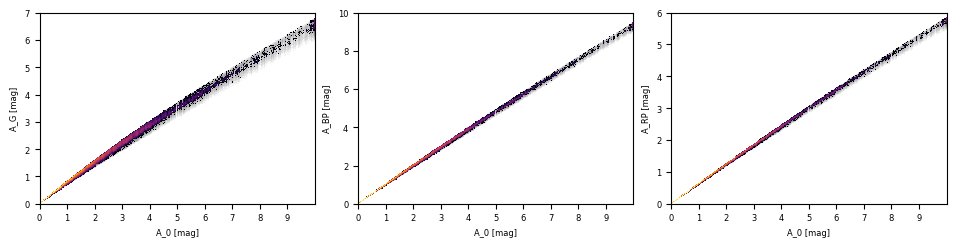

In [13]:
plt.rc('font', size=6.0)
inch = 2.54  # cm
width, height = 24/inch, 6/inch
plt.figure(figsize=(width, height), layout='constrained')

norm = 'log'

plt.subplot(1, 3, 1)
plt.hist2d(rgb['a0'], rgb['ag'], bins=300, cmap='Greys', norm=norm, rasterized=True)
plt.hist2d(rgb_lome['a0'], rgb_lome['ag'], bins=300, cmap='inferno', norm=norm, rasterized=True)
plt.xlabel("A_0 [mag]")
plt.xticks(np.linspace(0.0, 9.0, 10))
plt.ylabel("A_G [mag]")
plt.ylim(0.0, 7.0)

plt.subplot(1, 3, 2)
plt.hist2d(rgb['a0'], rgb['abp'], bins=300, cmap='Greys', norm=norm, rasterized=True)
plt.hist2d(rgb_lome['a0'], rgb_lome['abp'], bins=300, cmap='inferno', norm=norm, rasterized=True)
plt.xlabel("A_0 [mag]")
plt.xticks(np.linspace(0.0, 9.0, 10))
plt.ylabel("A_BP [mag]")
plt.ylim(0.0, 10.0)

plt.subplot(1, 3, 3)
plt.hist2d(rgb['a0'], rgb['arp'], bins=300, cmap='Greys', norm=norm, rasterized=True)
plt.hist2d(rgb_lome['a0'], rgb_lome['arp'], bins=300, cmap='inferno', norm=norm, rasterized=True)
plt.xlabel("A_0 [mag]")
plt.xticks(np.linspace(0.0, 9.0, 10))
plt.ylabel("A_RP [mag]")
plt.ylim(0.0, 6.0)

plt.show()
plt.savefig(fig_path / 'a0-am.pdf', dpi=config.fig_dpi)
plt.close()

### Fit A_m(A_0) neglecting the T_eff dependence

Fit by the low-metallicity stars only

In [14]:
def am_eval(A0, spl):
    c1, c2, c3, c4 = spl
    return c1*A0 + c2*A0**2 + c3*A0**3 + c4*A0**4

def am_fit(x, y):
    tofit = lambda A0, c1, c2, c3, c4 : am_eval(A0, (c1, c2, c3, c4))
    spl, _ = sp.optimize.curve_fit(tofit, x, y)
    return spl

tmp = rgb_lome[['a0', 'ag', 'abp', 'arp']].sort_values('a0')

# G
AG_fit_coef = am_fit(tmp['a0'].values, tmp['ag'].values)
print("AG_fit_coef: ", AG_fit_coef)

# BP
ABP_fit_coef = am_fit(tmp['a0'], tmp['abp'])
print("ABP_fit_coef:", ABP_fit_coef)

# RP
ARP_fit_coef = am_fit(tmp['a0'], tmp['arp'])
print("ARP_fit_coef:", ARP_fit_coef)

AG_fit_coef:  [ 8.32563220e-01 -3.64983807e-02  2.39856011e-03 -4.75030058e-05]
ABP_fit_coef: [ 1.04236029e+00 -2.27454444e-02  1.49285705e-03 -2.77271305e-05]
ARP_fit_coef: [ 6.40004034e-01 -9.25712352e-03  2.22280793e-04  8.41896596e-06]


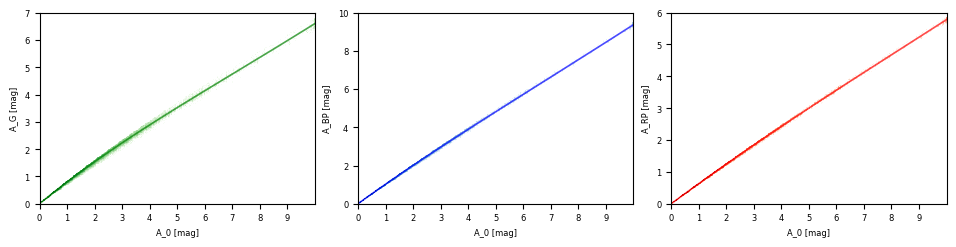

In [15]:
plt.rc('font', size=6.0)
inch = 2.54  # cm
width, height = 24/inch, 6/inch
plt.figure(figsize=(width, height), layout='constrained')

norm = 'log'
a0 = np.linspace(0.0, 10.0, 201)

plt.subplot(1, 3, 1)
plt.hist2d(rgb_lome['a0'], rgb_lome['ag'], bins=300, cmap='Greens', norm=norm, rasterized=True)
plt.plot(a0, am_eval(a0, AG_fit_coef), 'g', lw=1.2, alpha=0.7)
#plt.plot(a0, 8.20267543e-01*a0 - 3.38661275e-02*a0**2 + 2.55566043e-03*a0**3 - 8.13195644e-05*a0**4, 'grey', alpha=0.7)
plt.xlabel("A_0 [mag]")
plt.xticks(np.linspace(0.0, 9.0, 10))
plt.ylabel("A_G [mag]")
plt.ylim(0.0, 7.0)

plt.subplot(1, 3, 2)
plt.hist2d(rgb_lome['a0'], rgb_lome['abp'], bins=300, cmap='Blues', norm=norm, rasterized=True)
plt.plot(a0, am_eval(a0, ABP_fit_coef), 'b', lw=1.2, alpha=0.7)
plt.xlabel("A_0 [mag]")
plt.xticks(np.linspace(0.0, 9.0, 10))
plt.ylabel("A_BP [mag]")
plt.ylim(0.0, 10.0)

plt.subplot(1, 3, 3)
plt.hist2d(rgb_lome['a0'], rgb_lome['arp'], bins=300, cmap='Reds', norm=norm, rasterized=True)
plt.plot(a0, am_eval(a0, ARP_fit_coef), 'r', lw=1.2, alpha=0.7)
plt.xlabel("A_0 [mag]")
plt.xticks(np.linspace(0.0, 9.0, 10))
plt.ylabel("A_RP [mag]")
plt.ylim(0.0, 6.0)

plt.show()
plt.savefig(fig_path / 'a0-am_fit.pdf', dpi=config.fig_dpi)
plt.close()

## Calculate extinction maps

### Calculate the map for the monochromatic extinction, A_0

In [16]:
# Note the frame!
hp = HEALPix(nside=config.hpx_nside, order='nested', frame='icrs')
co = hp.healpix_to_skycoord(range(config.hpx_npix))
a0_map = dm.query(co)
print("min(a0_map), max(a0_map) =", np.nanmin(a0_map), np.nanmax(a0_map))

# Substitute NaNs by 20, i.e. holow pixels are of highest extinction pixels
a0_map[np.isnan(a0_map)] = 20.0

min(a0_map), max(a0_map) = 0.0003 9.9997


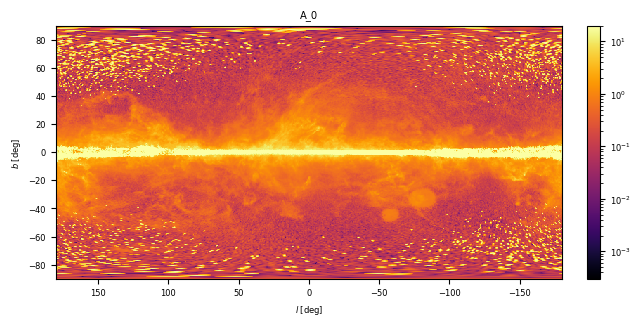

In [17]:
# Plot the sky map for extinction
plt.rc('font', size=6.0)
inch = 2.54  # cm
width, height = 16/inch, 8/inch
plt.figure(figsize=(width, height), layout='constrained')

utils.plot_hpxmap(a0_map, title="A_0")

plt.savefig(fig_path / 'a0_map.pdf', dpi=config.fig_dpi)
plt.show()
plt.close()

### Calculate the map in the Gaia bands

In [18]:
ag_map = am_eval(a0_map, AG_fit_coef)
ag_map[ag_map < 0.0] = 0.0

abp_map = am_eval(a0_map, ABP_fit_coef)
abp_map[abp_map < 0.0] = 0.0

arp_map = am_eval(a0_map, ARP_fit_coef)
arp_map[arp_map < 0.0] = 0.0

print("min(ag),  max(ag)  =", np.nanmin(ag_map), np.nanmax(ag_map))
print("min(abp), max(abp) =", np.nanmin(abp_map), np.nanmax(abp_map))
print("min(arp), max(arp) =", np.nanmin(arp_map), np.nanmax(arp_map))

min(ag),  max(ag)  = 0.0002497657 13.639912
min(abp), max(abp) = 0.00031270608 19.255543
min(arp), max(arp) = 0.00019200039 12.222513


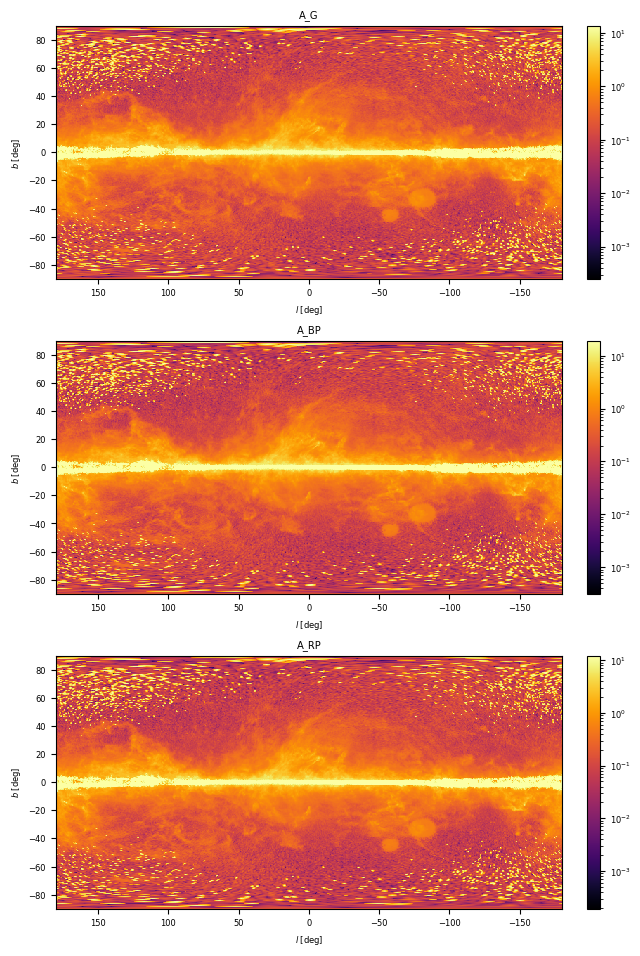

In [19]:
plt.rc('font', size=6.0)
inch = 2.54  # cm
width, height = 16/inch, 24/inch
plt.figure(figsize=(width, height), layout='constrained')

plt.subplot(3, 1, 1)
utils.plot_hpxmap(ag_map, title="A_G")

plt.subplot(3, 1, 2)
utils.plot_hpxmap(abp_map, title="A_BP")

plt.subplot(3, 1, 3)
utils.plot_hpxmap(arp_map, title="A_RP")

plt.savefig(fig_path / 'am_map.pdf', dpi=config.fig_dpi)
plt.show()
plt.close()

## Save the extinction maps

In [20]:
d = {}
d['ag_map'] = ag_map
d['abp_map'] = abp_map
d['arp_map'] = arp_map
# Save as a compressed archive
np.savez_compressed(cache_path / 'am_map.npz', **d)
del(d)